In [1]:
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
import multiprocessing as mp
from torch import FloatTensor, tanh
from torch.optim import SGD
from torch.nn import Module, Linear, Parameter
from torch.nn.init import xavier_normal_
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from sklearn.model_selection import KFold
import numpy as np
from numpy import loadtxt
import time
from sklearn.model_selection import train_test_split
global ms_result


def read_tr(file_path, test_size=0.15, random_state=42):
    # load tr data
    train = loadtxt(file_path, delimiter=',', usecols=range(1, 14), dtype=np.float64)

    # Esclude la prima colonna e le ultime tre colonne (target)
    x = train[:, :-3]
    y = train[:, -3:]  # Le ultime tre colonne rappresentano i target

    # Suddivide il dataset in set di addestramento e test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    return x_train, y_train, x_test, y_test


def read_ts():
    file = "./cup/ds/ML-CUP23-TS.csv"
    test = loadtxt(file, delimiter=',', usecols=range(1, 11), dtype=np.float64)

    return test


class Net(Module):

    def __init__(self, n_units=30, in_features=10, out_features=3):
        super(Net, self).__init__()

        # set up model parameters
        self.n_units = Parameter(FloatTensor(n_units), requires_grad=False)
        self.in_features = Parameter(FloatTensor(in_features), requires_grad=False)
        self.out_features = Parameter(FloatTensor(out_features), requires_grad=False)

        # input layer
        self.l_in = Linear(in_features=in_features, out_features=n_units)

        # hidden layers
        self.l2 = Linear(in_features=n_units, out_features=n_units)
        self.l3 = Linear(in_features=n_units, out_features=n_units)

        # output layer
        self.l_out = Linear(in_features=n_units, out_features=out_features)

    def forward(self, x):
        # input layer
        x = tanh(self.l_in(x))

        # hidden layers
        x = tanh(self.l2(x))
        x = tanh(self.l3(x))

        # output layer
        x = self.l_out(x)

        return x


# weights initialization function, as Glorot initialization (also called Xavier initialization)
def init_weights(m):
    if type(m) == Linear:
        xavier_normal_(m.weight)


# re-written loss function for PyTorch (with tensors)
def mean_euclidean_error(y_real, y_pred):
    return torch.mean(F.pairwise_distance(y_real, y_pred, p=2))


def make_train_step(model, loss_fn, optimizer):

    # Builds function that performs a step in the train loop
    def train_step(x, y):

        # set model to TRAIN mode
        model.train()
        # make predictions
        y_hat = model(x)
        # compute loss
        loss = loss_fn(y, y_hat)
        # compute gradients
        loss.backward()
        # update parameter and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        # return the loss
        return loss.item()

    # return the function that will be called inside the train loop
    return train_step


def plot_learning_curve(losses, val_losses, start_epoch=1, savefig=False, **kwargs):
    plt.plot(range(start_epoch, kwargs['epochs']), losses[start_epoch:])
    plt.plot(range(start_epoch, kwargs['epochs']), val_losses[start_epoch:])

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(['Loss TR', 'Loss VL'])
    plt.title(f'PyTorch Learning Curve \n {kwargs}')

    #if savefig:
    #    save_figure("pytorchNN", **kwargs)

    plt.show()


def fit(x, y, model, optimizer, loss_fn=mean_euclidean_error, epochs=200, batch_size=64, val_data=None):

    # create the train_step function for our model, loss function and optimizer
    train_step = make_train_step(model, loss_fn, optimizer)
    losses = []
    val_losses = []

    # change our data into tensors to work with PyTorch
    x_tensor = torch.from_numpy(x).float()
    y_tensor = torch.from_numpy(y).float()

    dataset = TensorDataset(x_tensor, y_tensor)

    # if validation data are given, use them. Else split the given development set
    if val_data:
        x_val, y_val = val_data
        x_val_tensor = torch.from_numpy(x_val).float()
        y_val_tensor = torch.from_numpy(y_val).float()

        val_data = TensorDataset(x_val_tensor, y_val_tensor)
        train_data = dataset

    else:
        # split dataset into train set and validation set (70% - 30%)
        train_size = int(0.7 * len(dataset))
        test_size = len(dataset) - train_size

        train_data, val_data = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

    # for each epoch...
    for epoch in range(epochs):
        epoch_losses = []
        for x_batch, y_batch in train_loader:
            # ...perform one train step and return the corresponding loss
            loss = train_step(x_batch, y_batch)
            epoch_losses.append(loss)

        losses.append(np.mean(epoch_losses))

        epoch_val_losses = []
        # perform validation
        with torch.no_grad():
            for x_val, y_val in val_loader:
                # set model to VALIDATION mode
                model.eval()
                # makes predictions
                y_hat = model(x_val)
                # computes loss
                val_loss = loss_fn(y_val, y_hat)
                epoch_val_losses.append(val_loss.item())

            val_losses.append(np.mean(epoch_val_losses))
    return losses, val_losses


def cross_validation(x, y, n_splits=10, epochs=200, batch_size=64, eta=0.003, alpha=0.85, lmb=0.0002):
    kfold = KFold(n_splits=n_splits, random_state=None, shuffle=False)
    cv_loss = []
    fit_times = []
    fold_idx = 1

    # for each fold (whose number is defined by n_splits) ...
    for tr_idx, vl_idx in kfold.split(x, y):

        # ... create and fit a different model ...
        model = Net()
        model.apply(init_weights)
        optimizer = SGD(model.parameters(), lr=eta, momentum=alpha, weight_decay=lmb)

        fit_time = time.time()
        loss_tr, loss_vl = fit(x[tr_idx], y[tr_idx], model=model, optimizer=optimizer, epochs=epochs,
                               batch_size=batch_size, val_data=(x[vl_idx], y[vl_idx]))

        fit_time = time.time() - fit_time
        fit_times.append(fit_time)

        # ... and save results ...
        cv_loss.append([loss_tr[-1], loss_vl[-1]])
        fold_idx += 1

    params = dict(eta=eta, alpha=alpha, lmb=lmb, epochs=epochs, batch_size=batch_size)

    # calculate average time to make the entire cross validation process
    mean_fit_time = np.mean(fit_times)
    return params, cv_loss, mean_fit_time


# callback function for the multiprocessing task
def log_ms_result(result):
    ms_result.append(result)


def model_selection(x, y):
    # define the grid search parameters
    eta_values = np.arange(start=0.003, stop=0.01, step=0.001)
    alpha_values = np.arange(start=0.4, stop=1, step=0.2)
    lmb_values = np.arange(start=0.0005, stop=0.001, step=0.0002)
    batch_sizes = [16, 32, 64]

    best_params = None
    min_loss = float('inf')

    ms_time = time.time()
    print("Starting Grid Search.")

    for eta in eta_values:
        for alpha in alpha_values:
            for lmb in lmb_values:
                for batch_size in batch_sizes:
                    params, cv_loss, fit_time = cross_validation(x, y, eta=eta, alpha=alpha, lmb=lmb, batch_size=batch_size)
                    mean_ts_loss = np.mean(cv_loss, axis=0)[1]

                    print(f"{params} \t TR {np.mean(cv_loss, axis=0)[0]:.4f} \t TS {mean_ts_loss:.4f} (Fit Time: {fit_time:.4f})")

                    if mean_ts_loss < min_loss:
                        min_loss = mean_ts_loss
                        best_params = params

    print("\nEnded Grid Search. ({:.4f})\n".format(time.time() - ms_time))
    print("\nBest score {:.4f} with {}\n".format(min_loss, best_params))
    
    return best_params

def predict(model, x_ts, x_its, y_its):
    # change our data into tensors to work with PyTorch
    x_ts = torch.from_numpy(x_ts).float()
    x_its = torch.from_numpy(x_its).float()
    y_its = torch.from_numpy(y_its).float()

    # predict on internal test set
    y_ipred = model(x_its)
    iloss = mean_euclidean_error(y_its, y_ipred)

    # predict on blind test set
    y_pred = model(x_ts)

    # return predicted target on blind test set,
    # and losses on internal test set
    return y_pred.detach().numpy(), iloss.item()


def pytorch_nn(ms=True):
    print("pytorch start\n")

    
    file_path="./cup/ds/ML-CUP23-TR.csv"
    # read training set
    x, y, x_its, y_its = read_tr(file_path)

    # choose model selection or hand-given parameters
    '''if ms:
        params = model_selection(x, y)
    else:
        params = dict(eta=0.003, alpha=0.85, lmb=0.0002, epochs=80, batch_size=64)
'''
    params = model_selection(x, y)
    # create and fit the model
    model = Net()
    model.apply(init_weights)
    optimizer = SGD(model.parameters(), lr=params['eta'], momentum=params['alpha'], weight_decay=params['lmb'])

    tr_losses, val_losses = fit(x, y, model=model, optimizer=optimizer,
                                batch_size=params['batch_size'], epochs=params['epochs'])

    y_pred, ts_losses = predict(model=model, x_ts=read_ts(), x_its=x_its, y_its=y_its)

    print("TR Loss: ", tr_losses[-1])
    print("VL Loss: ", val_losses[-1])
    print("TS Loss: ", np.mean(ts_losses))

    print("\npytorch end")

    plot_learning_curve(tr_losses, val_losses, savefig=True, **params)

    # generate csv file for MLCUP
    #write_blind_results(y_pred)  
    


pytorch start

Starting Grid Search.
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0005, 'epochs': 200, 'batch_size': 16} 	 TR 1.1379 	 TS 1.3370 (Fit Time: 9.2384)
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0005, 'epochs': 200, 'batch_size': 32} 	 TR 2.1115 	 TS 2.3608 (Fit Time: 5.1904)
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0005, 'epochs': 200, 'batch_size': 64} 	 TR 4.7321 	 TS 4.8706 (Fit Time: 2.8986)
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0007, 'epochs': 200, 'batch_size': 16} 	 TR 1.1672 	 TS 1.3971 (Fit Time: 7.9708)
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0007, 'epochs': 200, 'batch_size': 32} 	 TR 2.1019 	 TS 2.2894 (Fit Time: 4.9278)
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0007, 'epochs': 200, 'batch_size': 64} 	 TR 4.4955 	 TS 4.6148 (Fit Time: 2.6947)
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0009, 'epochs': 200, 'batch_size': 16} 	 TR 1.1516 	 TS 1.4269 (Fit Time: 8.2046)
{'eta': 0.003, 'alpha': 0.4, 'lmb': 0.0009, 'epochs': 200, 'batch_size': 32} 	 TR 2.1175 	 TS 2.2889 (Fit Time: 4.5697)
{'e

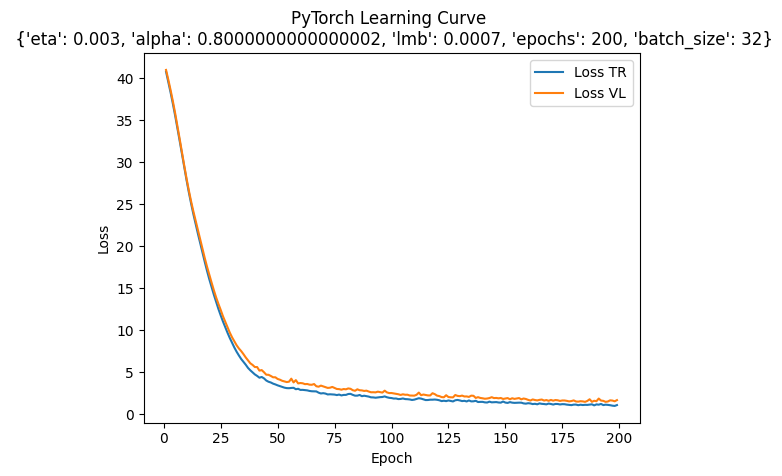

In [2]:
pytorch_nn()

Ended Grid Search. (9369.0962)


Best score 1.2361 with {'eta': 0.003, 'alpha': 0.8000000000000002, 'lmb': 0.0007, 'epochs': 200, 'batch_size': 32}

TR Loss:  1.0661633297016746
VL Loss:  1.6560055315494537
TS Loss:  1.4379831552505493